In [8]:
import networkx as nx

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.metrics import f1_score, accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from gensim.models import Word2Vec
import itertools
import math
import random
from joblib import Parallel, delayed

In [14]:
#随机游走
class RandomWalker:
    def __init__(self, G, p=1, q=1, use_rejection_sampling=False):
        """
        G:图
        p:Return parameter,controls the likelihood of immediately revisiting a node in the walk，方便后续扩展其他graph embedding算法
        q:In-out parameter,allows the search to differentiate between “inward” and “outward” nodes，方便后续扩展其他graph embedding算法
        use_rejection_sampling:whether to use the rejection sampling strategy in node2vec
        """
        self.G = G
        self.p = p
        self.q = q
        self.use_rejection_sampling = use_rejection_sampling
    #随机游走是可以重复访问已遍历节点的深度优先遍历算法
    def deepwalk_walk(self, walk_length, start_node):
        """
        walk_length:对于每个节点，每次游走的长度
        start_node：开始的节点
        """
        walk = [start_node]
        while len(walk) < walk_length:
            cur = walk[-1]
            cur_nbrs = list(self.G.neighbors(cur))
            if len(cur_nbrs) > 0:
                walk.append(random.choice(cur_nbrs))
            else:
                break
        return walk
    def node2vec_walk(self, walk_length, start_node):
        """
        walk_length:每次游走的长度
        start_node:游走的开始节点
        """
        G = self.G
        alias_nodes = self.alias_nodes
        alias_edges = self.alias_edges
        
        walk = [start_node]
        
        while len(walk) < walk_length:
            cur = walk[-1]
            cur_nbrs = list(G.neighbors(cur))
            if len(cur_nbrs) > 0:
                if len(walk) == 1:
                    #如果只有游走序列刚从起点开始，那就按照边权重用alias sample采样一个节点
                    walk.append(cur_nbrs[alias_sample(alias_nodes[cur][0], alias_nodes[cur][1])])
                else:
                    #如果已经有了游走过的节点，那就按照node2vec中每个节点的权重计算公式得到的权重 用alias sample采样一个节点
                    prev = walk[-2]
                    edge = (prev, cur)
                    next_node = cur_nbrs[alias_sample(alias_edges[edge][0], alias_edges[edge][1])]
                    walk.append(next_node)
            else:
                break
        return walk
    def node2vec_walk2(self, walk_length, start_node):
        """
        在node2vec中采用矩阵采样的思想 看懂大概 有需要再细究
        walk_length:每次随机游走的长度
        start_node:每次随机游走开始的节点
        KnightKing: A Fast Distributed Graph Random Walk Engine
        http://madsys.cs.tsinghua.edu.cn/publications/SOSP19-yang.pdf
        """
        def rejection_sample(inv_p, inv_q, nbrs_num):
            upper_bound = max(1,0, max(inv_p, inv_q))
            lower_bound = min(1.0, min(inv_p, inv_q))
            shatter = 0
            second_upper_bound = max(1.0, inv_q)
            #下面的操作话句话说就是当upper_bound是inv_p时
            if(inv_p > second_upper_bound):
                shatter = second_upper_bound / nbrs_num
                upper_bound = second_upper_bound + shatter
            return upper_bound, lower_bound, shatter
        G = self.G
        alias_nodes = self.alias_nodes
        inv_p = 1.0 / self.p
        inv_q = 1.0 / self.q
        walk = [start_node]
        while len(walk) < walk_length:
            cur = walk[-1]
            cur_nbrs = list(G.neightbors(cur))
            if len(cur_nbrs) > 0:
                if len(walk) == 1:
                    walk.append(cur_nbrs[alias_sample(alias_nodes[cur][0], alias_nodes[cur][1])])
                else:
                    upper_bound, lower_bound, shatter = rejection_sample(inv_p, inv_q, len(cur_nbrs))
                    prev = walk[-2]
                    pre_nbrs = set(G.neighbors(prev))
                    while True:
                        prob = random.random() * upper_bound
                        if prob + shatter >= upper_bound:
                            next_node = prev
                            break
                        next_node = cur_nbrs[alias_sample(alias_nodes[cur][0], alias_nodes[cur][1])]
                        if prob < lower_bound:
                            break
                        if prob < inv_p and next_node == prev:
                            break
                        _prob = 1.0 if next_node in prev_nbrs else inv_q
                        if prob < _prob:
                            break
                    walk.append(next_node)
            else:
                break
        return walks
    def simulate_walks(self, num_walks, walk_length, workers=1, verbose=0):
        """
        num_walks:所有节点随机游走的次数
        walk_length:每次随机游走的长度
        wokers,verbose:用于多线程处理中
        """
        G = self.G
        nodes = list(G.nodes())
        walks = self._simulate_walks(nodes, num_walks, walk_length)
        #多线程同时处理
#         result = Parallel(n_jobs=workers, verbose=verbose,)(delayed(self._simulate_walks)(nodes, num, walk_length) for num in 
#                                                            partition_num(num_walks, workers))
#         walks = list(itertools.chain(*results))
        return walks
    def _simulate_walks(self, nodes, num_walks, walk_length,):
        """
        nodes:所有结点
        num_walks:所有节点随机游走的次数
        walk_length:每次游走的长度
        """
        walks = []
        for _ in range(num_walks):
            random.shuffle(nodes)
            for v in nodes:
                if self.p == 1 and self.q == 1:
                    walks.append(self.deepwalk_walk(walk_length=walk_length, start_node=v))
                elif self.use_rejection_sampling:
                    #是否采用拒绝采样
                    walks.append(self.node2vec_walk2(walk_length=walk_length, start_node=v))
                else:
                    #论文node2vec中采用的时alias sample
                    walks.append(self.node2vec_walk(walk_length=walk_length, start_node=v))
        return walks
    def get_alias_edge(self, t, v):
        """
        compute unnormalized transition probability between nodes v and its neighbors give the previous visited node t
        用论文里面提到的公式计算每个节点的采样概率
        """
        G = self.G
        p = self.p
        q = self.q
        
        unnormalized_probs = []
        for x in G.neighbors(v):
            weight = G[v][x].get('weight', 1.0) #w_vx
            if x == t: #d_tx == 0
                unnormalized_probs.append(weight / p)
            elif G.has_edge(x, t): #d_tx == 1
                unnormalized_probs.append(weight)
            else: #d_tx > 1
                unnormalized_probs.append(weight / q)
        norm_const = sum(unnormalized_probs)
        normalized_probs = [float(u_prob) / norm_const for u_prob in unnormalized_probs]
        return create_alias_table(normalized_probs)
    def preprocess_transition_probs(self):
        #preprocessing of transition probabilities for guiding the random walks
        #再随机游走之前计算好游走时会用到的相关概率
        G = self.G
        alias_nodes = {}
        for node in G.nodes():
            unnormalized_probs = [G[node][nbr].get('weight', 1.0) for nbr in G.neighbors(node)]
            norm_const = sum(unnormalized_probs)
            normalized_probs = [float(u_prob) / norm_const for u_prob in unnormalized_probs]
            alias_nodes[node] = create_alias_table(normalized_probs)
        if not self.use_rejection_sampling:
            alias_edges = {}
            
            for edge in G.edges():
                alias_edges[edge] = self.get_alias_edge(edge[0],edge[1])
                if not G.is_directed():
                    alias_edges[(edge[1], edge[0])] = self.get_alias_edge(edge[1], edge[0])
                self.alias_edges = alias_edges
        self.alias_nodes = alias_nodes
        return
def create_alias_table(area_ratio):
    """
    #构造alias sample对应的那个表，有accept和alias，accept[i]保存了事件i再第i列表对应的概率，alias[i]保存了第i列中不是事件i的事件编号
    area_ratio:sum(area_ratio)=1
    return:accept, alias
    """
    l = len(area_ratio)
    accept,alias = [0] * l, [0] * l
    small, large = [], []
    area_ratio_ = np.array(area_ratio) * l
    for i, prob in enumerate(area_ratio_):
        if prob < 1.0:
            small.append(i)
        else:
            large.append(i)
    while small and large:
        small_idx, large_idx = small.pop(), large.pop()
        accept[small_idx] = area_ratio_[small_idx]
        alias[small_idx] = large_idx
        area_ratio_[large_idx] = area_ratio_[large_idx] - (1 - area_ratio_[small_idx])
        if area_ratio_[large_idx] < 1.0:
            small.append(large_idx)
        else:
            large.append(large_idx)
    while large:
        large_idx = large.pop()
        accept[large_idx] = 1
    while small:
        small_idx = small.pop()
        accept[small_idx] = 1
    return accept, alias
def alias_sample(accept, alias):
    """
    #根据alias sample进行采样，输入的是某个节点的所有邻居节点的权重所构成的alias sample表(体现在accept,alias上)
    #alias sample的采样方法是：产生一个1-N之间的数字，该数字表示我取表中第i列保存的节点，再随机生成一个0-1的概率值，
    #如果概率值小于accept[i]，则本次采样节点为i,否则本次采样节点为alias[i]
    return:sample index
    """
    N = len(accept)
    i = int(np.random.random() * N)
    r = np.random.random()
    if r < accept[i]:
        return i
    else:
        return alias[i]
def partition_num(num, workers):
    if num % workers == 0:
        return [num // workers] * workers
    else:
        return [num // workers] * workers + [num % workers]

In [15]:
class Node2Vec:
    def __init__(self, graph, walk_length, num_walks, p=1.0, q=1.0, workers=1, use_rejection_sampling=False):
        self.graph = graph
        self._embeddings = {}
        self.walker = RandomWalker(graph, p=p, q=q, use_rejection_sampling=use_rejection_sampling)
        print('Preprocess transition probs...')
        self.walker.preprocess_transition_probs()
        
        self.sentences = self.walker.simulate_walks(num_walks=num_walks, walk_length=walk_length, workers=workers, verbose=1)
    
    def train(self, embed_size=128, window_size=5, workers=3, iter=5, **kwargs):
        kwargs['sentences'] = self.sentences
        kwargs['min_count'] = kwargs.get('min_count', 0)
        kwargs['size'] = embed_size
        kwargs['sg'] = 1 #node2vec use skip-gram
        kwargs['hs'] = 0 #node2vec not use hierarchical softmax
        kwargs['workers'] = workers
        kwargs['window'] = window_size
        kwargs['iter'] = iter
        
        print('Learning embedding vectors...')
        model = Word2Vec(**kwargs)
        print('leanring embedding vectors done!')
        self.w2v_model = model
        return model
    def get_embeddings(self, ):
        if self.w2v_model is None:
            print('model not train')
            return {}
        self._embeddings = {}
        for word in self.graph.nodes():
            self._embeddings[word] = self.w2v_model.wv[word]
        return self._embeddings

In [16]:
#构建多分类的分类器，因为wiki的数据是多分类数据，使用基于deepwalk生成的每个节点的向量表示来训练模型预测标签结果
#deekwalk算法的应用，利用deepwalk算法进行wiki上的节点分类
class TopKRanker(OneVsRestClassifier):
    def predict(self, X, top_k_list):
        probs = np.asarray(super(TopKRanker,self).predict_proba(X))
        all_labels = []
        for i, k in enumerate(top_k_list):
            probs_ = probs[i, :]
            labels = self.classes_[probs_.argsort()[-k:]].tolist()
            probs_[:] = 0
            probs_[labels] = 1
            all_labels.append(probs_)
        return np.asarray(all_labels)
class Classifier(object):
    def __init__(self, embeddings, clf):
        self.embeddings = embeddings
        self.clf = TopKRanker(clf)
        #对于多分类任务，便捷的生成多分类标签，比如标签为[1,2,3]，会生成[[1,0,0],[0,1,0],[0,0,1]]
        self.binarizer = MultiLabelBinarizer(sparse_output=True)
    def train(self, X, Y, Y_all):
        self.binarizer.fit(Y_all)
        #训练时用每个节点的deepwalk的向量表示数据
        X_train = [self.embeddings[x] for x in X]
        Y = self.binarizer.transform(Y)
        self.clf.fit(X_train, Y)
    def evaluate(self, X, Y):
        top_k_list = [len(l) for l in Y]
        Y_ = self.predict(X, top_k_list)
        Y = self.binarizer.transform(Y)
        #f1-score各种方式的计算结果
        averages = ['micro', 'macro', 'samples', 'weighted']
        results = {}
        for average in averages:
            results[average] = f1_score(Y, Y_, average=average)
        results['acc'] = accuracy_score(Y, Y_)
        print(results)
        return results
    def predict(self, X, top_k_list):
        #预测时 用每个节点的deepwalk向量表示数据
        X_ = np.asarray([self.embeddings[x] for x in X])
        Y = self.clf.predict(X_, top_k_list=top_k_list)
        return Y
    def split_train_evaluate(self, X, Y, train_percent, seed=0):
        state = np.random.get_state()
        training_size = int(train_percent * len(X))
        np.random.seed(seed)
        shuffle_indices = np.random.permutation(np.arange(len(X)))
        X_train = [X[shuffle_indices[i]] for i in range(training_size)]
        Y_train = [Y[shuffle_indices[i]] for i in range(training_size)]
        X_test = [X[shuffle_indices[i]] for i in range(training_size, len(X))]
        Y_test = [Y[shuffle_indices[i]] for i in range(training_size, len(X))]
        
        self.train(X_train, Y_train, Y)
        np.random.set_state(state)
        return self.evaluate(X_test,Y_test)
#读取数据函数
def read_node_label(filename, skip_head=False):
    fin = open(filename, 'r')
    X = []
    Y = []
    while 1:
        if skip_head:
            fin.readline()
        l = fin.readline()
        if l == '':
            break
        vec = l.strip().split(' ')
        X.append(vec[0])
        Y.append(vec[1:])
    fin.close()
    return X, Y

In [17]:
def evaluate_embeddings(embeddings):
    X, Y = read_node_label('./wiki/wiki_labels.txt')
    tr_frac = 0.8
    print('Training classifier using {:.2f}% nodes...'.format(tr_frac * 100))
    clf = Classifier(embeddings=embeddings, clf=LogisticRegression())
    clf.split_train_evaluate(X, Y, tr_frac)
def plot_embeddings(embeddings,):
    X, Y = read_node_label('./wiki/wiki_labels.txt')
    
    emb_list = []
    for k in X:
        emb_list.append(embeddings[k])
    emb_list = np.array(emb_list)
    
    model = TSNE(n_components=2)
    node_pos = model.fit_transform(emb_list)
    
    plt.figure(figsize=(12,12))
    color_idx = {}
    for i in range(len(X)):
        color_idx.setdefault(Y[i][0], [])
        color_idx[Y[i][0]].append(i)
    
    for c, idx in color_idx.items():
        plt.scatter(node_pos[idx, 0], node_pos[idx, 1], label=c)
    plt.legend()
    plt.show()

In [12]:
#构建图
G = nx.read_edgelist('./wiki/Wiki_edgelist.txt', create_using=nx.DiGraph(), nodetype=None, data=[('weight', int)])

In [18]:
model = Node2Vec(G, walk_length=10, num_walks=3, p=0.25, q=4, workers=1, use_rejection_sampling=0)
model.train(window_size=5, iter=3, min_count=2)
embeddings = model.get_embeddings()
print(embeddings['1249'])

Preprocess transition probs...
Learning embedding vectors...
leanring embedding vectors done!
[-0.06039566  0.05288341 -0.13908574 -0.02750591 -0.19805618 -0.17635739
 -0.00042098 -0.16307314 -0.05722325  0.15809251  0.02382103  0.0562704
  0.1223688  -0.06390408 -0.05985515  0.07790884 -0.0023571  -0.1705877
  0.09289639 -0.02676519 -0.0910167  -0.18466596 -0.1881333  -0.05783565
 -0.00153758  0.10005257 -0.04543249 -0.14214799 -0.02544392  0.03441517
 -0.10933124 -0.0151903   0.05393672 -0.02990659 -0.13280143 -0.12884282
  0.19177067  0.03892384 -0.14957537  0.04126853  0.10511066 -0.07593788
 -0.02071356 -0.07222384  0.125728   -0.12570707  0.01851237  0.1012088
  0.02089549  0.00479961  0.06626307  0.0850163   0.02085299 -0.02112033
  0.05687507 -0.11235274  0.11427882  0.05927404 -0.07500813 -0.07554754
 -0.08626437 -0.04125463 -0.07928387 -0.16360241 -0.03537316  0.00546546
 -0.02712291  0.001966    0.03642206 -0.06119563 -0.00461224 -0.02881281
  0.11150103  0.05636836  0.18423

In [20]:
evaluate_embeddings(embeddings)

Training classifier using 80.00% nodes...
{'micro': 0.4303534303534304, 'macro': 0.31145137077683904, 'samples': 0.4303534303534304, 'weighted': 0.4221128485037787, 'acc': 0.4303534303534304}


/data1/guoyuhao/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


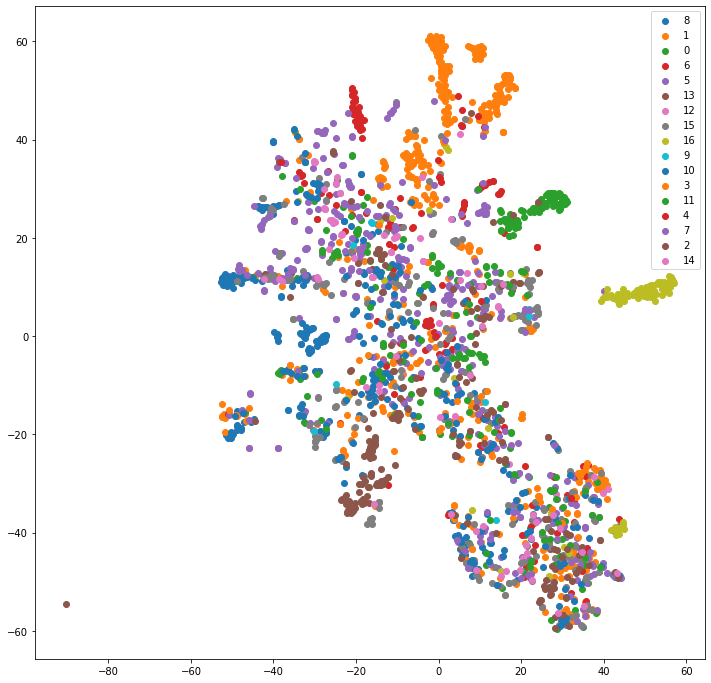

In [19]:
plot_embeddings(embeddings)